## LD水平可视化

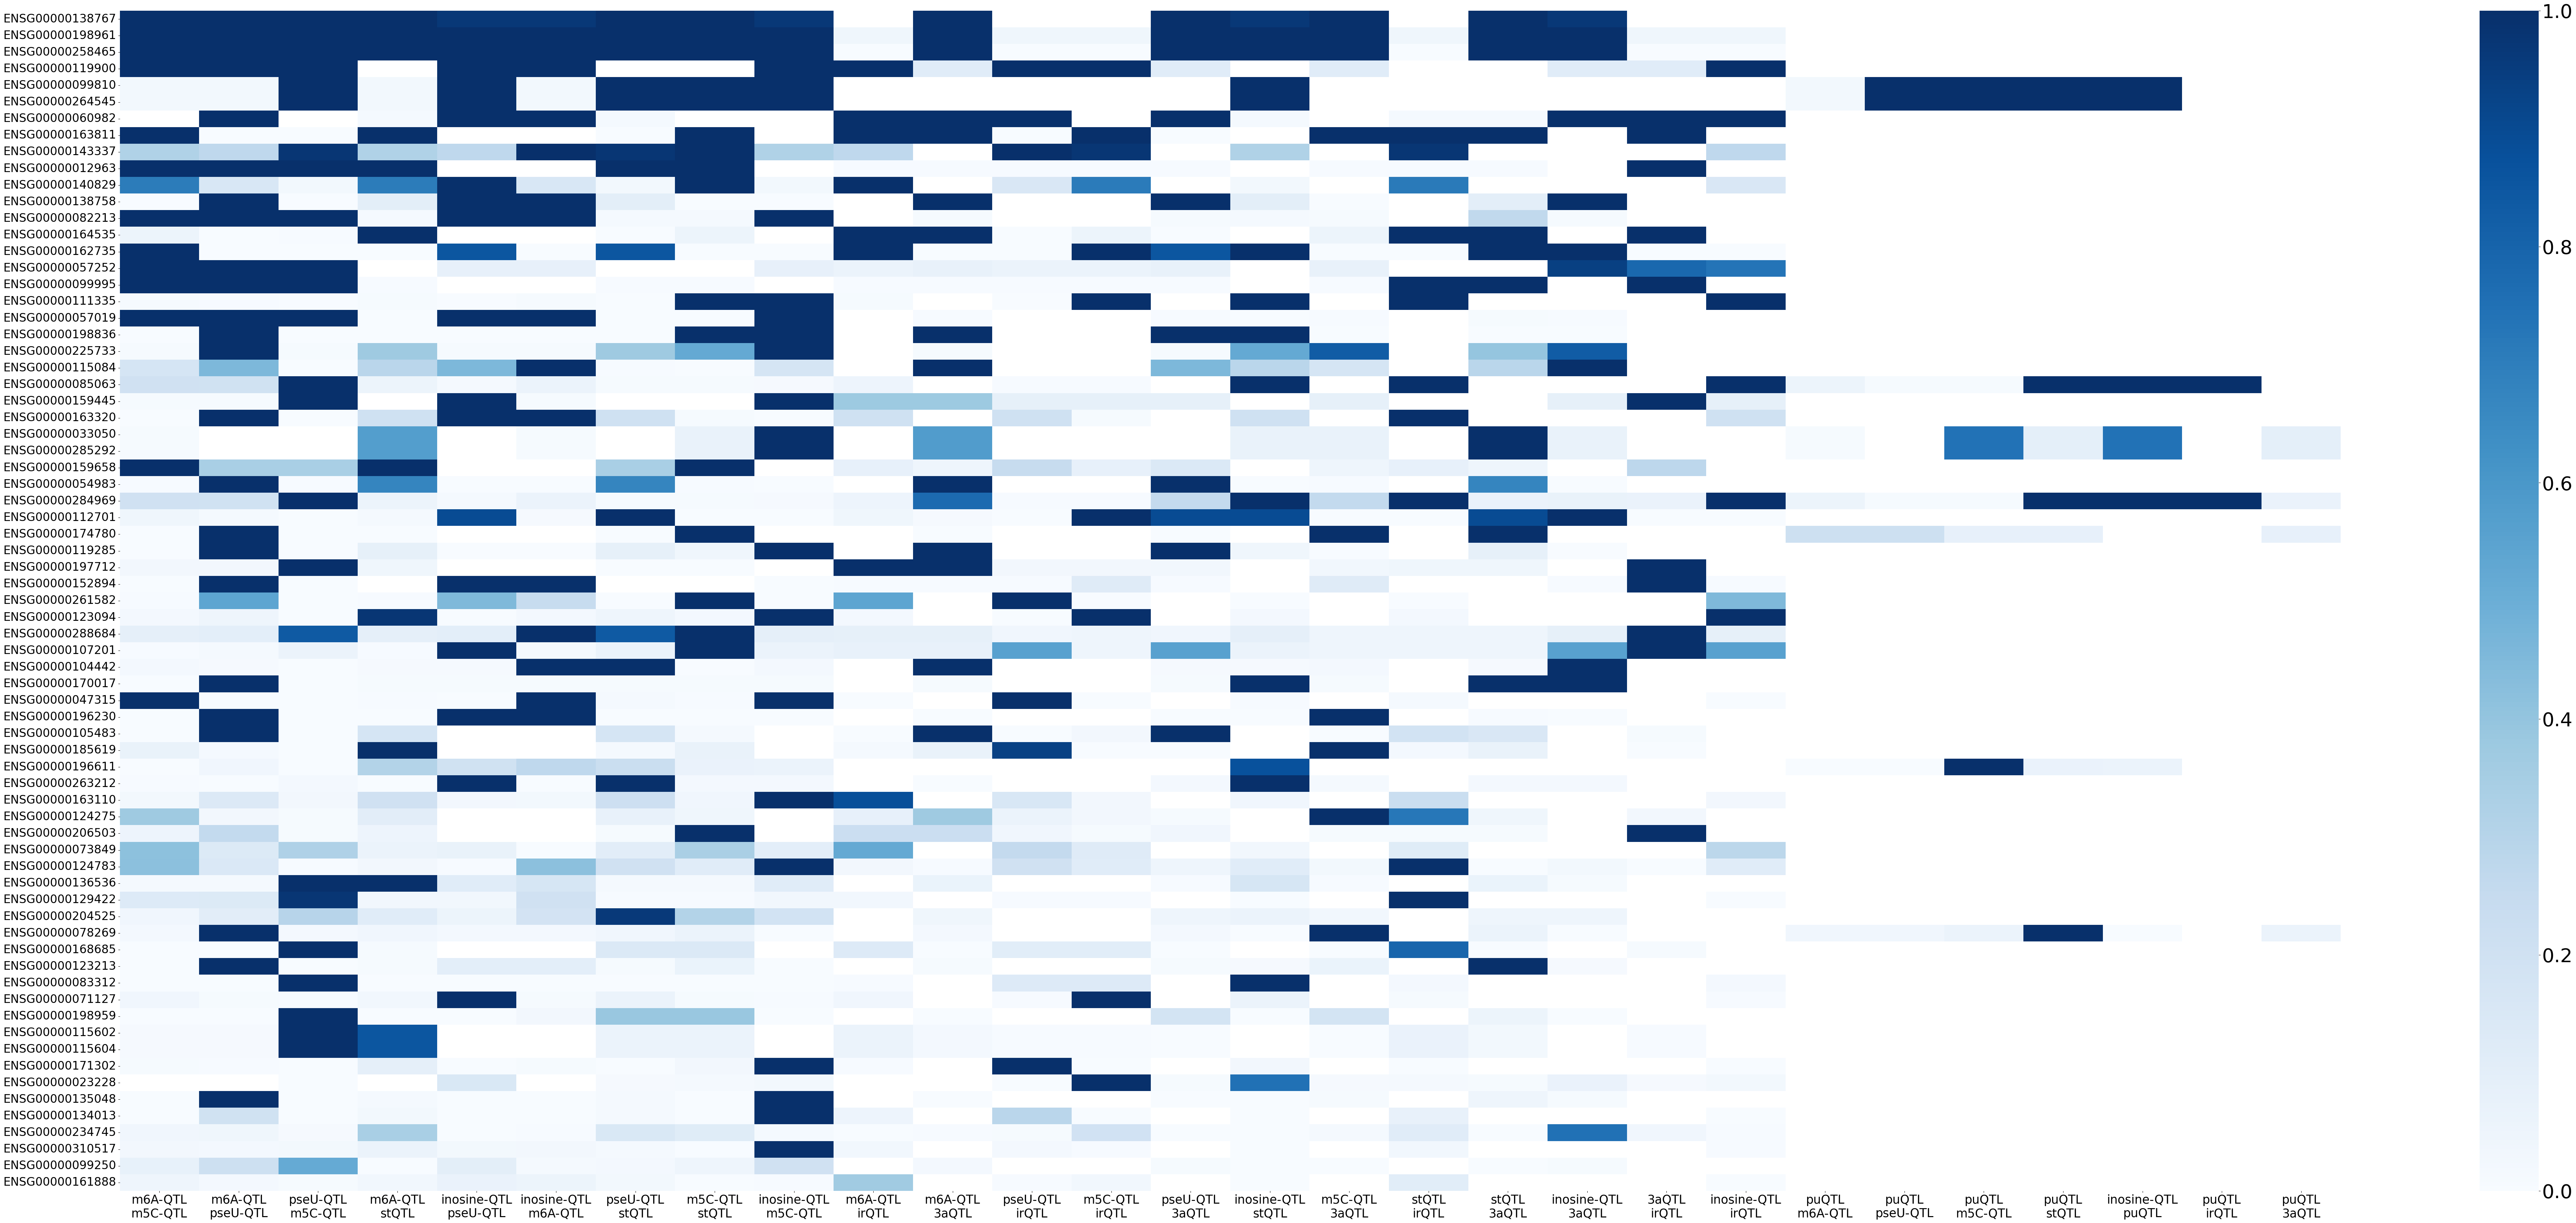

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np

def create_sorted_ld_heatmap(directory, min_occurrences):
    """
    创建一个排序后的热图，展示所有_LD.csv文件中R_sq值的分布，纵坐标为在至少min_occurrences个QTL组合中出现的基因。

    Args:
        directory (str): 包含_LD.csv文件的文件夹路径。
        min_occurrences (int): 基因需要出现的最小QTL组合数量。
    """

    # 1. 读取和筛选数据
    ld_files = [f for f in os.listdir(directory) if f.endswith('_LD.csv')]
    ld_data = {}
    gene_occurrences = {}
    qtl_gene_counts = {}  # 存储QTL组合在多少个基因中出现

    for file in ld_files:
        match = re.match(r'(.+?)_LD\.csv', file)
        if match:
            qtl_pair = match.group(1)
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path, usecols=['geneID', 'R_sq'])
            ld_data[qtl_pair] = df.set_index('geneID')['R_sq']
            for gene in df['geneID'].unique():
                gene_occurrences[gene] = gene_occurrences.get(gene, 0) + 1
            qtl_gene_counts[qtl_pair] = len(df['geneID'].unique())

    filtered_genes = [gene for gene, count in gene_occurrences.items() if count >= min_occurrences]
    filtered_genes = sorted(filtered_genes)

    heatmap_df = pd.DataFrame(index=filtered_genes)
    for qtl_pair, r_sq_series in ld_data.items():
        heatmap_df[qtl_pair] = r_sq_series.reindex(filtered_genes)

    # 2. QTL组合排序
    sorted_qtls = sorted(qtl_gene_counts.items(), key=lambda item: item[1], reverse=True)
    sorted_qtls = [qtl[0] for qtl in sorted_qtls]

    # 3. 基因排序
    gene_sort_values = []
    for gene in filtered_genes:
        r_sq_values = heatmap_df.loc[gene].dropna().values
        if len(r_sq_values) > 0:
            gene_sort_values.append((gene, np.mean(r_sq_values), len(r_sq_values)))
        else:
            gene_sort_values.append((gene, 0, 0)) # 没有r2值的gene放在最后

    gene_sort_values.sort(key=lambda x: (x[1], x[2]), reverse=True)
    sorted_genes = [gene[0] for gene in gene_sort_values]

    # 修改 geneID，删除点号及其后面的内容
    cleaned_genes = [re.split(r'\.', gene)[0] for gene in sorted_genes]

    heatmap_df = heatmap_df.loc[sorted_genes, sorted_qtls]

    # 4. 绘制热图
    plt.figure(figsize=(len(ld_data) * 3, len(cleaned_genes) * 0.5)) # 修改figsize的第二个参数为len(cleaned_genes)
    heatmap = sns.heatmap(heatmap_df, cmap='Blues', vmin=0, vmax=1)
    
    xticklabels = ['\n'.join(qtl.split('_')) for qtl in sorted_qtls]
    plt.xticks(ticks=np.arange(len(sorted_qtls)) + 0.5, labels=xticklabels, rotation=0, fontsize=25)
    
    plt.yticks(ticks=np.arange(len(cleaned_genes)) + 0.5, labels=cleaned_genes, fontsize=24) # 修改yticks的label为cleaned_genes
    
    # 调整颜色条刻度标签字体大小
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=40)  # 设置颜色条刻度标签字体大小
    
    plt.tight_layout()
    plt.show()

# 使用示例
directory = '/mnt/hpc/home/xuxinran/DirectSeq/8_downsteam/leadSNP_dis_LD'
create_sorted_ld_heatmap(directory, 15)

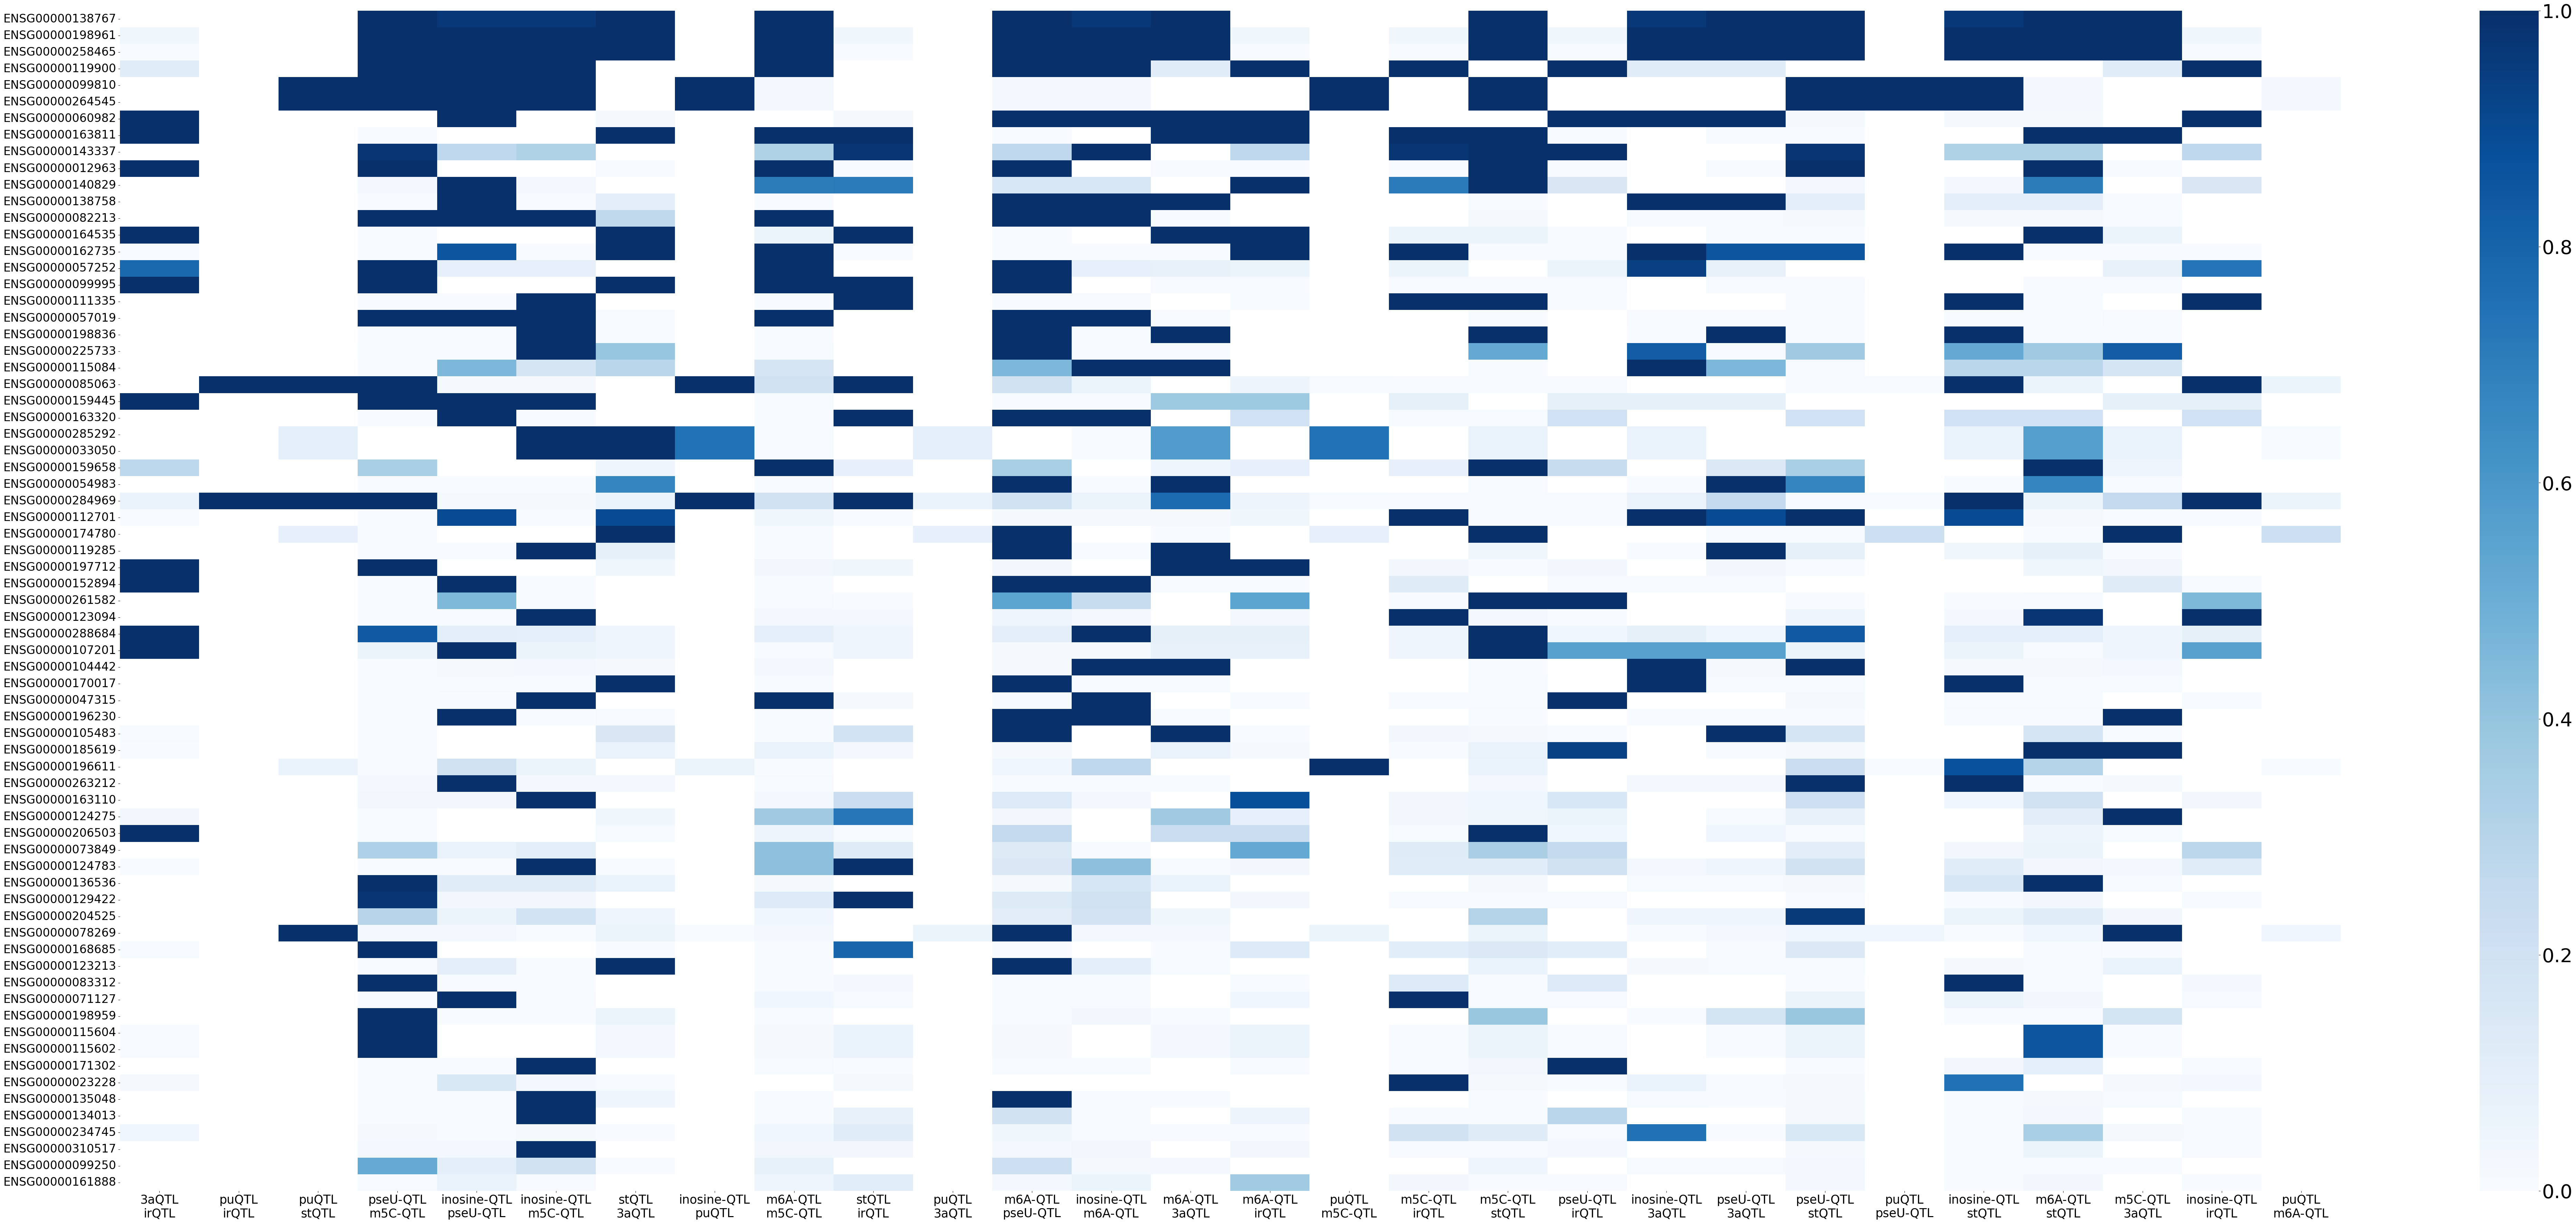

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np

def create_sorted_ld_heatmap(directory, min_occurrences):
    """
    创建一个排序后的热图，横纵坐标均按照连锁不平衡平均值（连锁不平衡得分总和/基因数量）的大小排序。

    Args:
        directory (str): 包含_LD.csv文件的文件夹路径。
        min_occurrences (int): 基因需要出现的最小QTL组合数量。
    """

    # 1. 读取和筛选数据
    ld_files = [f for f in os.listdir(directory) if f.endswith('_LD.csv')]
    ld_data = {}
    gene_occurrences = {}
    qtl_avg_rsq = {}

    for file in ld_files:
        match = re.match(r'(.+?)_LD\.csv', file)
        if match:
            qtl_pair = match.group(1)
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path, usecols=['geneID', 'R_sq'])
            ld_data[qtl_pair] = df.set_index('geneID')['R_sq']
            gene_occurrences.update({gene: gene_occurrences.get(gene, 0) + 1 for gene in df['geneID'].unique()})
            qtl_avg_rsq[qtl_pair] = df['R_sq'].mean()

    filtered_genes = [gene for gene, count in gene_occurrences.items() if count >= min_occurrences]
    heatmap_df = pd.DataFrame(index=filtered_genes)
    for qtl_pair, r_sq_series in ld_data.items():
        heatmap_df[qtl_pair] = r_sq_series.reindex(filtered_genes)

    # 2. QTL组合排序（按照平均R_sq值从大到小）
    sorted_qtls = sorted(qtl_avg_rsq.items(), key=lambda item: item[1], reverse=True)
    sorted_qtls = [qtl[0] for qtl in sorted_qtls]

    # 3. 基因排序（按照平均R_sq值从大到小）
    gene_avg_rsq = heatmap_df.mean(axis=1).sort_values(ascending=False)
    sorted_genes = gene_avg_rsq.index.tolist()

    # 修改 geneID，删除点号及其后面的内容
    cleaned_genes = [re.split(r'\.', gene)[0] for gene in sorted_genes]

    heatmap_df = heatmap_df.loc[sorted_genes, sorted_qtls]

    # 4. 绘制热图
    plt.figure(figsize=(len(ld_data) * 3, len(cleaned_genes) * 0.5))
    heatmap = sns.heatmap(heatmap_df, cmap='Blues', vmin=0, vmax=1)

    xticklabels = ['\n'.join(qtl.split('_')) for qtl in sorted_qtls]
    plt.xticks(ticks=np.arange(len(sorted_qtls)) + 0.5, labels=xticklabels, rotation=0, fontsize=25)

    plt.yticks(ticks=np.arange(len(cleaned_genes)) + 0.5, labels=cleaned_genes, fontsize=24)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=40)

    plt.tight_layout()
    plt.show()

# 使用示例
directory = '/mnt/hpc/home/xuxinran/DirectSeq/8_downsteam/leadSNP_dis_LD'
create_sorted_ld_heatmap(directory, 15)

In [10]:
(12+6)/(11+1+12+12+6)

0.42857142857142855

In [28]:
import pandas as pd

def analyze_ld_data(file_path):
    """
    分析LD数据，生成用于科学论文文字描述的结果。

    Args:
        file_path (str): LD数据CSV文件路径。
    """

    # 1. 读取数据
    df = pd.read_csv(file_path)

    # 2. 总体概括
    mean_r_sq = df['R_sq'].mean()
    print(f"在分析两两QTL之间的连锁不平衡（LD）时，我们观察到平均r²值为{mean_r_sq:.2f}。")

    # 3. 分类讨论
    high_ld = df[df['R_sq'] > 0.8]
    medium_ld = df[(df['R_sq'] > 0.2) & (df['R_sq'] <= 0.8)]
    low_ld = df[df['R_sq'] <= 0.2]

    print("\n高LD组 (r² > 0.8):")
    if not high_ld.empty:
        print(high_ld[['QTL_Pair', 'geneID', 'R_sq']].to_string(index=False))
    else:
        print("无")

    print("\n中等LD组 (0.2 < r² <= 0.8):")
    if not medium_ld.empty:
        print(medium_ld[['QTL_Pair', 'geneID', 'R_sq']].to_string(index=False))
    else:
        print("无")

    print("\n低LD组 (r² <= 0.2):")
    if not low_ld.empty:
        print(low_ld[['QTL_Pair', 'geneID', 'R_sq']].to_string(index=False))
    else:
        print("无")

    # 4. 统计数据支持
    total_pairs = len(df)
    low_ld_count = len(low_ld)
    print(f"\n在所有{total_pairs}个QTL对中，有{low_ld_count}个QTL对的r²值低于0.2，表明它们之间存在较低的关联性。")

# 使用示例
file_path = 'ld_data.csv'  # 替换为你的文件路径
analyze_ld_data(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'ld_data.csv'